In [1]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
#from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(df, share_type='amount', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, model='additive', period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], model='additive', period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(20,6))
    axs[0].set_title('OBSERVED', fontsize=14)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=14)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. 
    #Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=14)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=14)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

In [3]:
import glob
import pandas as pd

def pd_read_pattern(pattern, filesNo):
    files = glob.glob(pattern)
    print(len(files))
    df = pd.DataFrame()
    fc =0
    for f in files:
        if fc >= filesNo:
            break    
        # Concat Instead of append
        df = pd.concat([df,pd.read_csv(f, low_memory=False)])
        fc += 1
        
        

    return df.reset_index(drop=True)

ztedf = pd_read_pattern('..\ZTE_NBI\CallAccess_FDD_*.csv', 20)
ztedf.head()

96


,Begin Time,End Time,Granularity,SubnetWork ID,SubnetWork Name,ManagedElement ID,Managed Element,eNodeB ID,eNodeB Name,E-UTRAN FDD Cell ID,...,Number of Cell DRB Admission Failure due to Not Enough CPU Resource(times),Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times),Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit)
0,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,21,...,0,0,0,0,0,0,900,9,16,1
1,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,22,...,0,0,0,0,0,0,900,13,14,3
2,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,23,...,0,0,0,0,0,0,900,13,52,5
3,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,31,...,0,0,0,0,0,0,900,2,1,0
4,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,32,...,0,0,0,0,0,0,900,2,18,3


In [4]:
df = ztedf.copy()
metrics_list = df.columns.tolist()[14:]

import numbers
import numpy as np
#isinstance(df[m], numbers.Number),
metrics_list_fin = []
for m in metrics_list:
    #print('{} {}'.format(m,df[m].dtype))
    if df[m].dtype == np.int64 or df[m].dtype == np.float64:
        r = df[m].sum()
        if r != 0:
            metrics_list_fin.append(m)
            #print(m)
#df.info()
#metrics_list_fin
print(len(metrics_list))
print(len(metrics_list_fin))

181
76


In [5]:
# Granularity 15 minutes
#df.columns.tolist()[3:14]
eNodeB = ztedf['eNodeB Name'].unique()
cellName = ztedf['E-UTRAN\xa0FDD\xa0Cell Name'].unique()

In [8]:
# Check for missing values
columns_missing_values = {}
df = ztedf.copy()
for c in df.columns:
    msv = df[df[c].isna()| df[c].eq(' ')].shape[0]
    if msv > 0:
        columns_missing_values[c] = (msv,msv/df.shape[0]*100)
    
columns_missing_values

{'Number of Successful Access Using Group A Preamble(unit)': (458,
  0.2294796123898949),
 'Number of Successful Access Using Group B Preamble(unit)': (458,
  0.2294796123898949),
 'Number of Available Preamble(unit)': (458, 0.2294796123898949),
 'Number of Available Dedicated Preamble(unit)': (458, 0.2294796123898949),
 'Number of  Msg0 Scheduled by ENB(times)': (458, 0.2294796123898949),
 'Number of  Msg0 Scheduled by ENB Because of SRS Jump(unit)': (458,
  0.2294796123898949),
 'Number of  Msg0 Scheduled by ENB Because of UL HARQ Fail(unit)': (458,
  0.2294796123898949),
 'Number of  Msg0 Scheduled by ENB Because of DL HARQ Fail(unit)': (458,
  0.2294796123898949),
 'Number of PDCCH Order Non-contention Msg1(unit)': (458, 0.2294796123898949),
 'Number of Non-Contention Handover Msg1(unit)': (458, 0.2294796123898949),
 'Number of Msg1 discarded(times)': (458, 0.2294796123898949),
 'Number of Reducing contention Msg1 False Alarm Based on TA Threshold(unit)': (458,
  0.2294796123898949

In [18]:
df = ztedf.copy()
df = df.dropna().reset_index().drop('index',axis=1)

#https://towardsdatascience.com/hands-on-climate-time-series-clustering-using-machine-learning-with-python-6a12ce1607f9
#time_series_data = df.dropna().reset_index().drop('index',axis=1)
#time_series_data['datetime'] = pd.to_datetime(time_series_data['Begin Time'])
#time_series_data.head()


#df[metrics_list].corr().style.background_gradient(cmap='coolwarm', vmin=0.269278, vmax=1)

C:\Users\GeorgiosCh\AppData\Local\Temp\2\ipykernel_3348\3930502968.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df  = df.groupby(['datetime']).mean()


array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

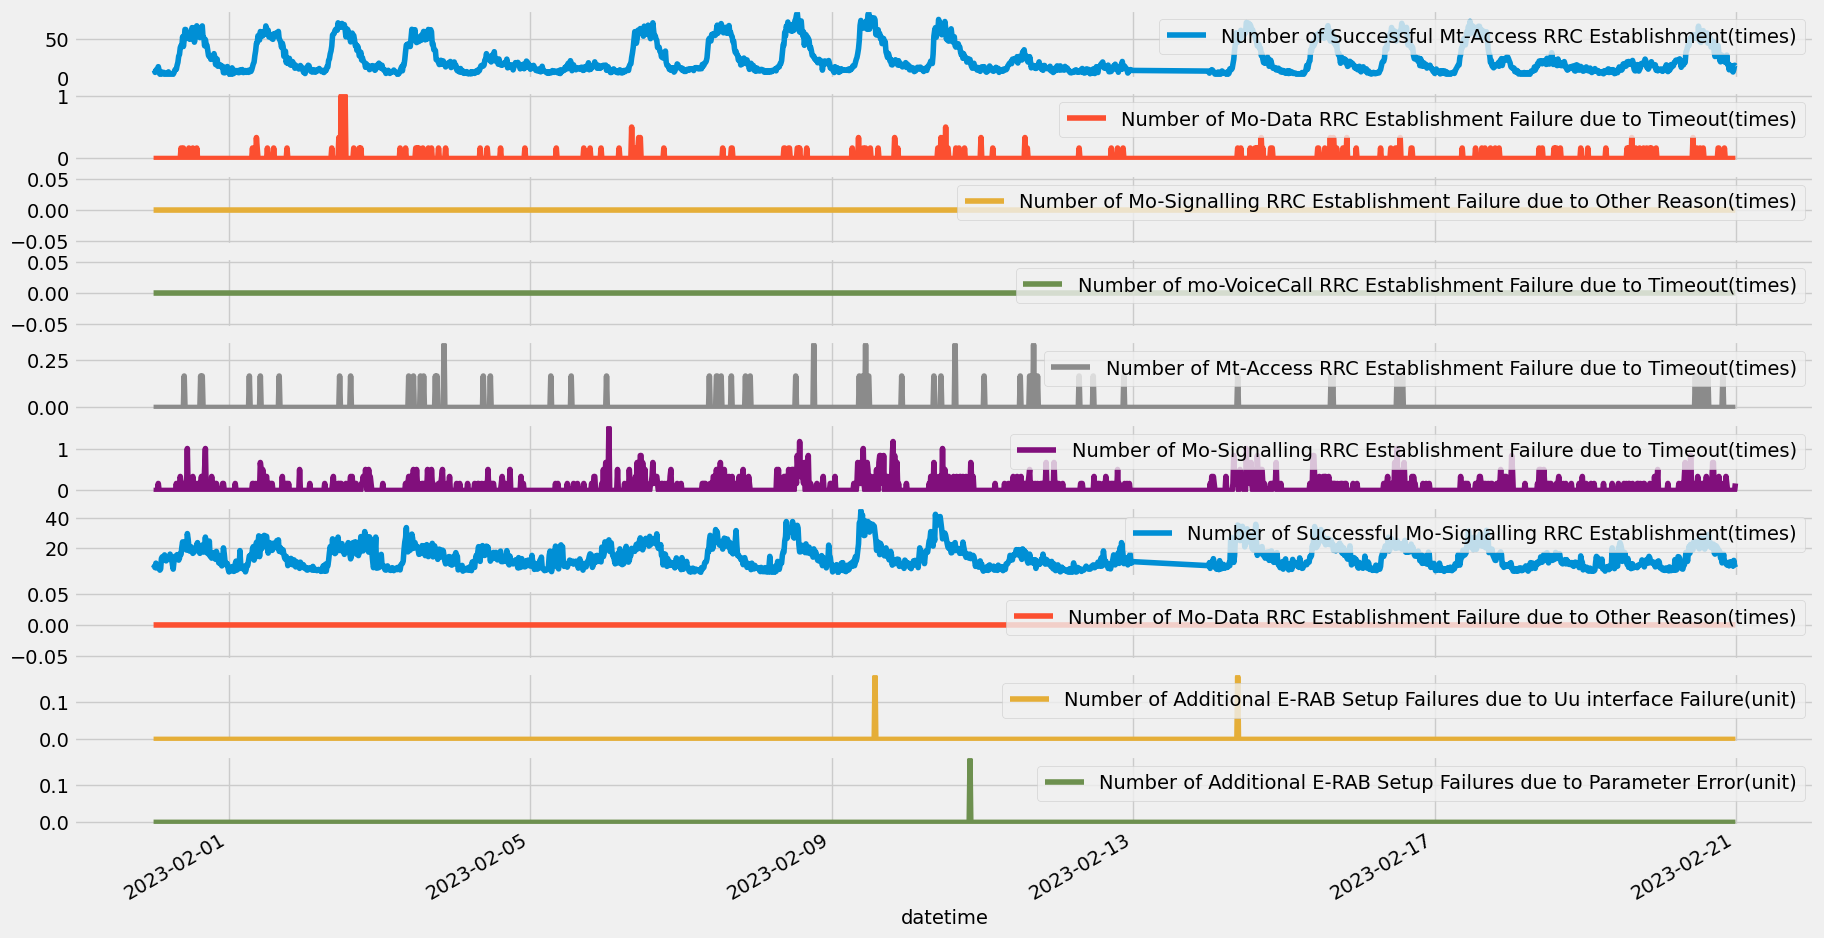

In [6]:
df = ztedf.loc[ztedf['eNodeB Name']=='LIM045'].copy()
df['datetime'] = pd.to_datetime(df['Begin Time'])
#df['datetime'] = df['date'].dt.strftime('%Y%m') 
df  = df.groupby(['datetime']).mean()
 
# Using a inbuilt style to change
# the look and feel of the plot
plt.style.use("fivethirtyeight")
 
df[metrics_list_fin[0:10]].plot(subplots=True, figsize=(20, 12))

In [7]:
df[metrics_list[0:2]].corr().style.background_gradient(cmap='coolwarm', vmin=0.269278, vmax=1)

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times)
Number of Successful Mt-Access RRC Establishment(times),1.000000,0.200159
Number of Mo-Data RRC Establishment Failure due to Timeout(times),0.200159,1.000000


### Multivariate Feature Selection
https://scikit-learn.org/stable/modules/feature_selection.html

In [8]:
from sklearn.feature_selection import VarianceThreshold

df = ztedf.loc[ztedf['eNodeB Name']=='LIM045'].copy()
df['datetime'] = pd.to_datetime(df['Begin Time'])

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
x = sel.fit_transform(df[metrics_list_fin])
lable = sel.get_feature_names_out()

In [9]:
dfnew = pd.DataFrame(data=x, columns=lable)
print(dfnew.shape)
df2 = df['datetime'].to_frame().reset_index()
print(df2.shape)

#df2 = pd.concat([df2, dfnew], axis=0)
#df2.shape
df2 = pd.merge(df2,dfnew, right_index=True, left_index=True)
df2 = df2.drop(columns=['index'])
df2.shape
#pd.merge(dfnew,df[list('datetime')])
#dfnew.merge(df[['datetime']])

(11520, 19)
(11520, 2)


(11520, 21)

In [59]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of Successful Mt-Access RRC Establishment(times),11520.0,24.624306,24.592486,0.0,6.0,16.0,36.0,172.0
Number of Successful Mo-Signalling RRC Establishment(times),11520.0,13.641667,15.025223,0.0,3.0,9.0,19.0,118.0
Number of Successful Context Modify (times),11520.0,0.856684,1.628443,0.0,0.0,0.0,1.0,15.0
Number of Mo-Signalling RRC Establishment Request(times),11520.0,13.724740,15.084144,0.0,3.0,9.0,19.0,118.0
Number of Mt-Access RRC Establishment Request(times),11520.0,24.629687,24.597929,0.0,6.0,16.0,36.0,172.0
Number of Successful RRC Connection Re-establishment Triggered by Handover Failure(times),11520.0,0.162760,0.701951,0.0,0.0,0.0,0.0,22.0
Number of Successful RRC Connection Re-establishment Triggered by Other(times),11520.0,0.264670,0.993687,0.0,0.0,0.0,0.0,48.0
Number of RRC Connection Re-establishment Request Triggered by Other(times),11520.0,0.352083,1.099051,0.0,0.0,0.0,0.0,48.0
Number of RRC Connection Re-establishment Request Triggered by Handover Failure(times),11520.0,0.170139,0.716439,0.0,0.0,0.0,0.0,22.0
Number of Msg0 Scheduled by ENB(times),11520.0,0.824132,3.270507,0.0,0.0,0.0,0.0,64.0


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

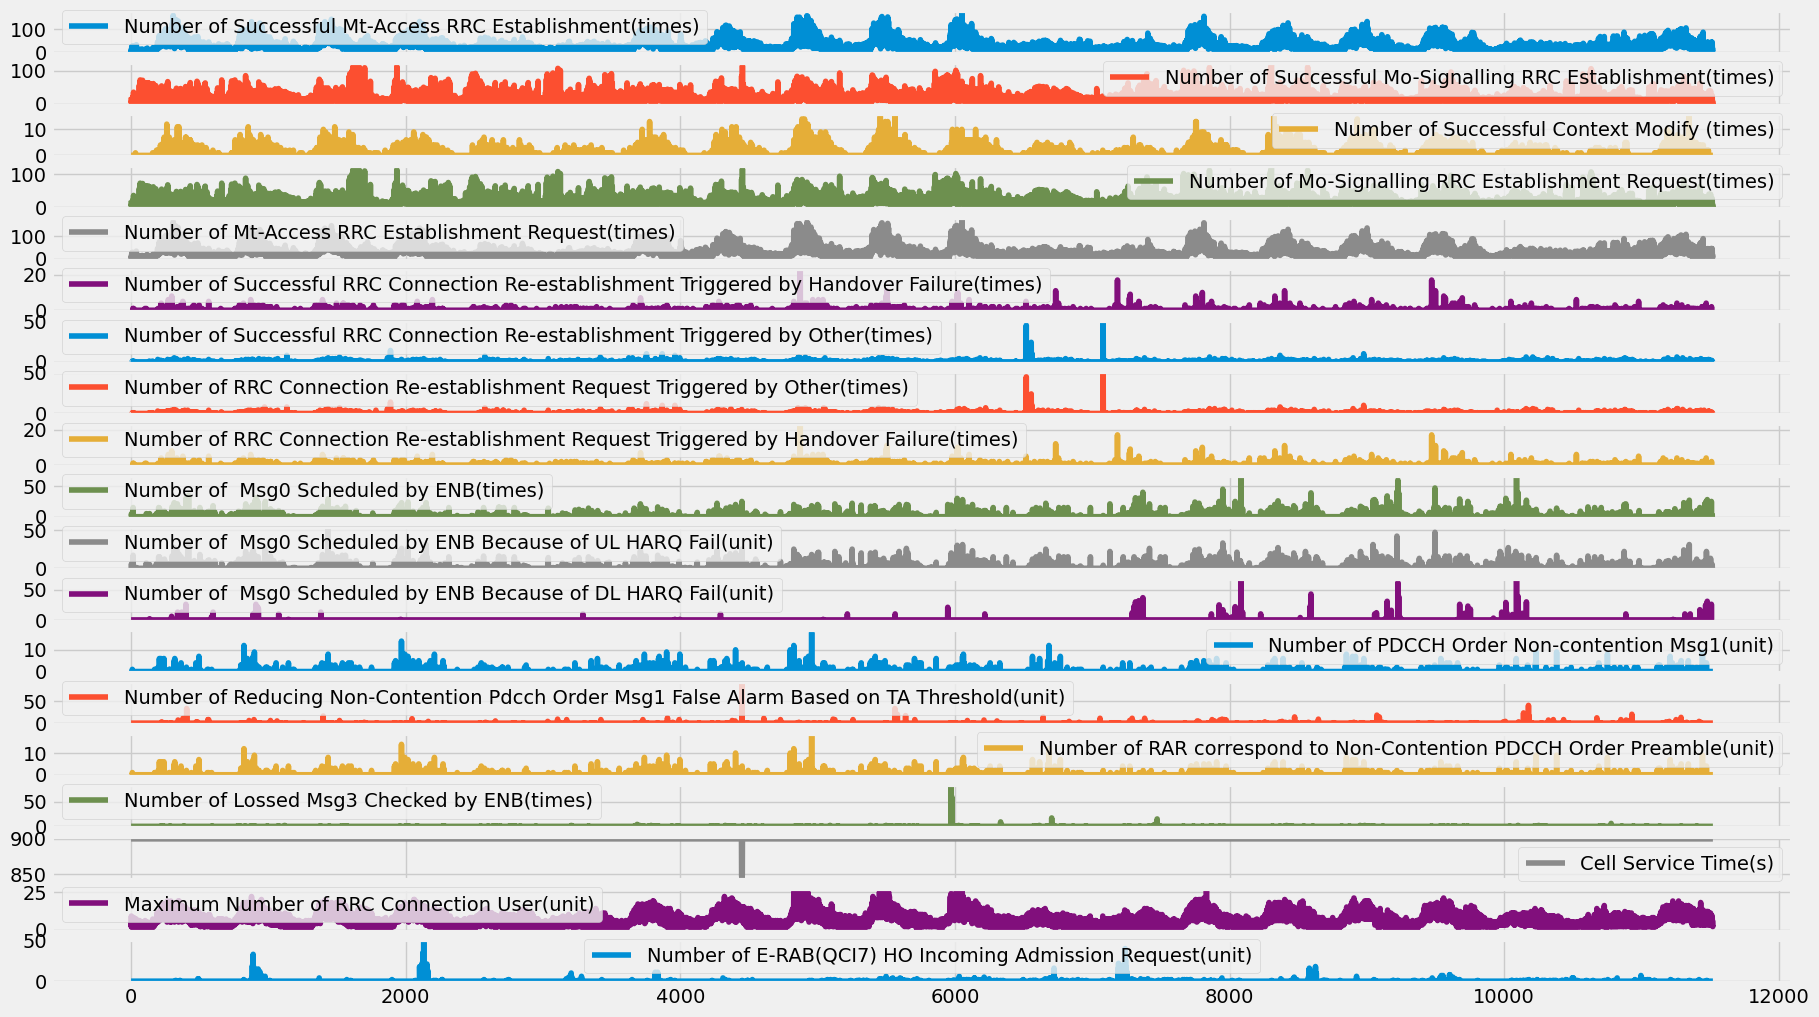

In [11]:
df2[lable].plot(subplots=True, figsize=(20, 12))

In [201]:
# Min Max Scaler
scaler = MinMaxScaler((0, 1))
ts = df2.copy()
ts2 = scaler.fit_transform(ts[lable])

for i in range(len(lable)):
    ts[lable[i]] = ts2.T[i]

ts.shape
ts.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of Successful Mt-Access RRC Establishment(times),11520.0,0.143165,0.142980,0.0,0.034884,0.093023,0.209302,1.0
Number of Successful Mo-Signalling RRC Establishment(times),11520.0,0.115607,0.127332,0.0,0.025424,0.076271,0.161017,1.0
Number of Successful Context Modify (times),11520.0,0.057112,0.108563,0.0,0.000000,0.000000,0.066667,1.0
Number of Mo-Signalling RRC Establishment Request(times),11520.0,0.116311,0.127832,0.0,0.025424,0.076271,0.161017,1.0
Number of Mt-Access RRC Establishment Request(times),11520.0,0.143196,0.143011,0.0,0.034884,0.093023,0.209302,1.0
Number of Successful RRC Connection Re-establishment Triggered by Handover Failure(times),11520.0,0.007398,0.031907,0.0,0.000000,0.000000,0.000000,1.0
Number of Successful RRC Connection Re-establishment Triggered by Other(times),11520.0,0.005514,0.020702,0.0,0.000000,0.000000,0.000000,1.0
Number of RRC Connection Re-establishment Request Triggered by Other(times),11520.0,0.007335,0.022897,0.0,0.000000,0.000000,0.000000,1.0
Number of RRC Connection Re-establishment Request Triggered by Handover Failure(times),11520.0,0.007734,0.032565,0.0,0.000000,0.000000,0.000000,1.0
Number of Msg0 Scheduled by ENB(times),11520.0,0.012877,0.051102,0.0,0.000000,0.000000,0.000000,1.0


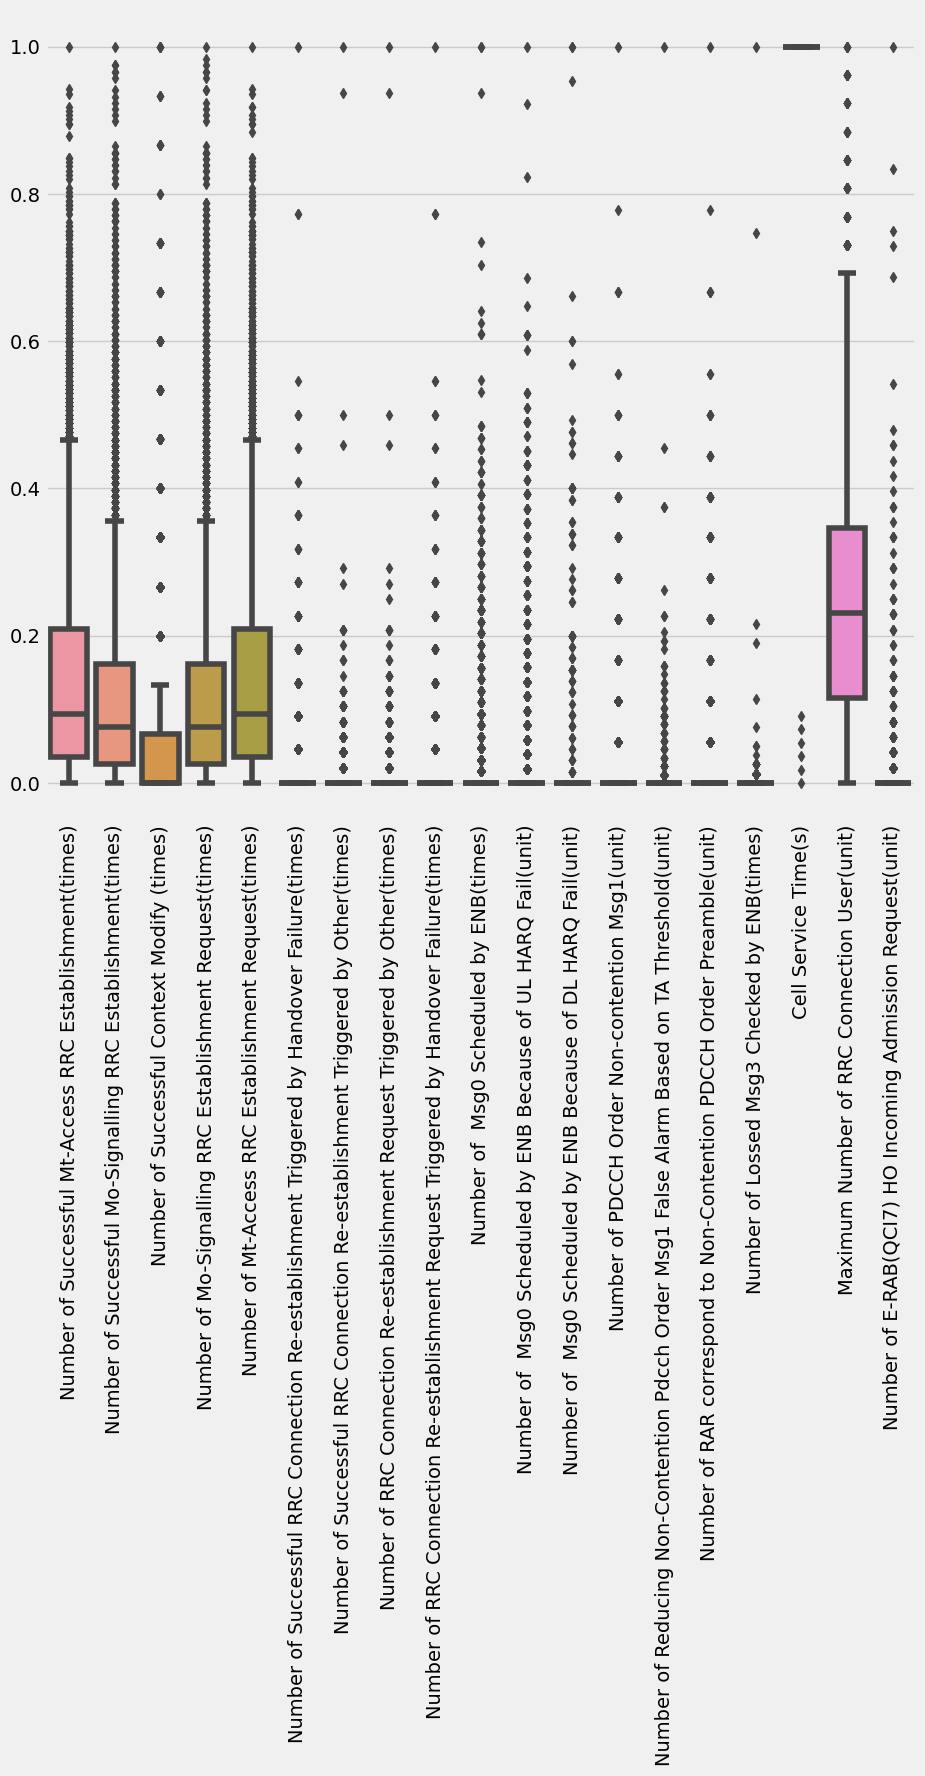

In [202]:
### Plot Outliers
import seaborn as sns # data visualization library  
plt.figure(figsize=(10,10))
sns.boxplot(data=ts[lable])
plt.xticks(rotation=90)
plt.show()

### Find Outliers

In [152]:
def find_boundaries(df, variable,q1=0.01,q2=0.99):
    # the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

def get_outliers(df,variable,q1=0.01,q2=0.99):
    outlier = df.copy()
    upper_boundary,lower_boundary =  find_boundaries(df,variable,q1,q2)
    print('{}-{}'.format(upper_boundary,lower_boundary))
    outlier  = outlier.loc[(outlier[variable] < lower_boundary)|(outlier[variable] > upper_boundary)]
    #outlier[variable] = np.where(outlier[variable] > upper_boundary, upper_boundary,
    #                   np.where(outlier[variable] < lower_boundary, lower_boundary, outlier[variable]))
    return outlier

outliers = get_outliers(ts,col)
outliers['datetime'].unique

0.13636363636363635-0.0


<bound method Series.unique of 219     2023-01-31 09:00:00
271     2023-01-31 11:15:00
296     2023-01-31 12:15:00
377     2023-01-31 15:30:00
565     2023-01-31 23:30:00
                ...        
10197   2023-02-18 16:45:00
10525   2023-02-19 06:30:00
10978   2023-02-20 01:15:00
11257   2023-02-20 13:00:00
11470   2023-02-20 21:45:00
Name: datetime, Length: 73, dtype: datetime64[ns]>

### Decompose Time-Series to See Components (Trend, Seasonality, Noise, etc)

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose

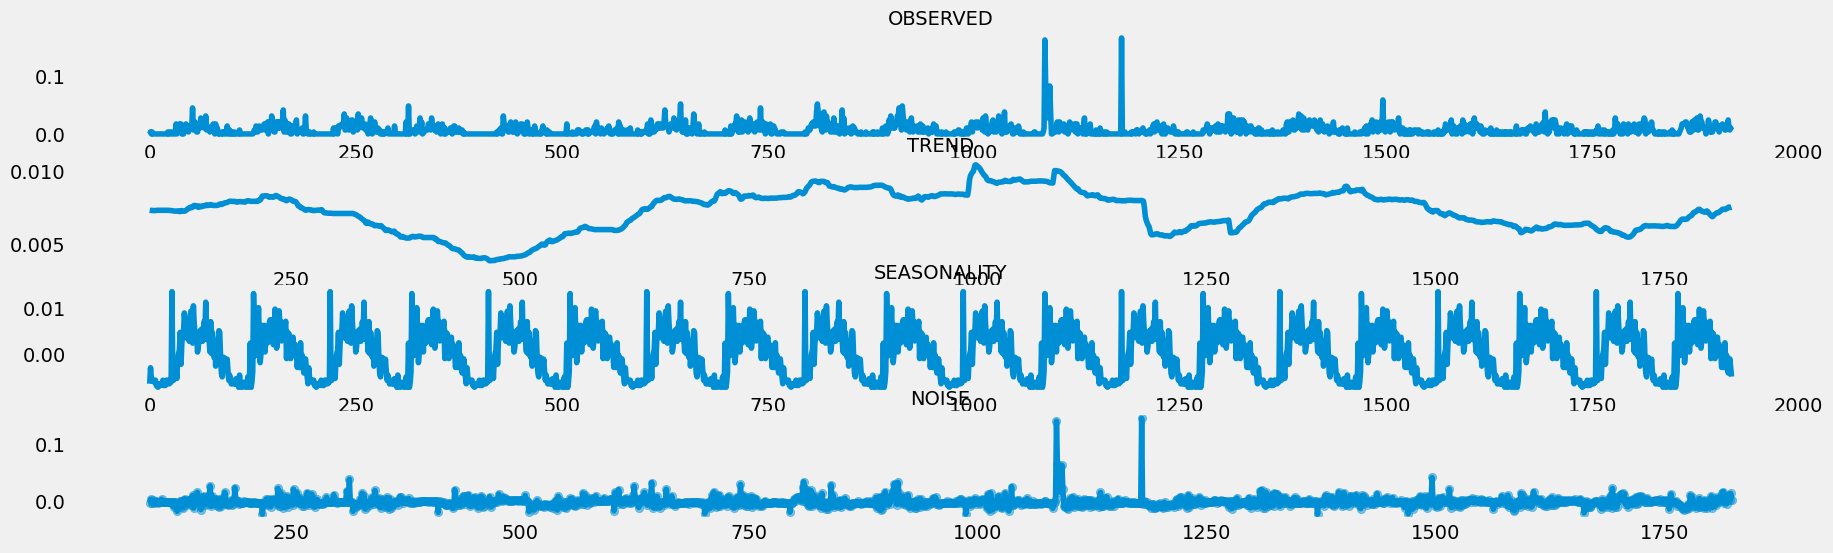

In [446]:
df_plt = ts.copy() 
col = df_plt.columns.values[8]
#df_plt['datetime'] = df_plt['datetime'].dt.date
df_plt = df_plt.groupby('datetime').mean().reset_index()

#df_plt = df_plt.set_index('datetime')
#df_plt.index =  pd.DatetimeIndex(df_plt.index)
#df_plt = df_plt[col].resample('H').mean().reset_index()
#df_plt = df_plt.set_index('datetime')

decompose(df_plt,col,'all' ,192) #'all'
#print(col)
#df_plt
#sd = seasonal_decompose(df2[lable[2]][1:1000], model='additive', period=24)
#sd.plot()
#df_plt

datetime
2023-01-31 00:00:00    0.003788
2023-01-31 01:00:00    0.000000
2023-01-31 02:00:00    0.000000
2023-01-31 03:00:00    0.000000
2023-01-31 04:00:00    0.003788
                         ...   
2023-02-20 19:00:00    0.001894
2023-02-20 20:00:00    0.007576
2023-02-20 21:00:00    0.013258
2023-02-20 22:00:00    0.009470
2023-02-20 23:00:00    0.005682
Freq: H, Name: Number of Successful RRC Connection Re-establishment Triggered by Handover Failure(times), Length: 504, dtype: float64

In [447]:
#We investigate the possibility to get the running mean for a window of 30-60-90 days \
#in order to make the distribution of values more linear
#As you increase the windows the average become more and more linear
import plotly.graph_objects as go

df_plt = ts.copy()
df_plt = df_plt.set_index('datetime')
df_plt.index =  pd.DatetimeIndex(df_plt.index)
df_plt = df_plt[col].resample('H').mean()

DateMVA1 = df_plt.rolling(window=48).mean()
DateMVA2 = df_plt.rolling(window=48).std()


fig = go.Figure()

fig.add_trace(go.Scatter(x=df_plt.index, y=df_plt.values,
                    mode='lines',
                    name='Amount per Day')
             )

fig.add_trace(go.Scatter(x=DateMVA1.index, y=DateMVA1.values,
                    mode='lines',
                    name='Moving Average for 48 Hours')
             )

fig.add_trace(go.Scatter(x=DateMVA2.index, y=DateMVA2.values,
                    mode='lines',
                    name='Moving Average for 48 Hours')
             )


fig.show()

In [448]:
#perform the augmented Dickey-Fuller test:
## https://koalatea.io/python-augment-dickey-fuller-test/
    
    
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

df_plt = ts.copy()

col = df_plt.columns.values[6]
df_plt = df_plt.set_index('datetime')
df_plt.index =  pd.DatetimeIndex(df_plt.index)

df_plt = df_plt[col].resample('H').mean().to_frame()
df_plt = df_plt.rolling(window=48).mean()
df_plt = df_plt.dropna()


adfuller(df_plt[col])
#df_plt
#kpss(df_plt[col])

#Test statistic: -11.315654352326138,
#P-value: 1.2084858263518312e-20

#Since the p-value is less than .05, thus we can reject the null hypothesis as the .05 level. 
#This suggest that our time series is stationary. We know this is true since we generated white noise.
#This means the time series is stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

(-1.6647839533297675,
 0.44934202820848146,
 4,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 -5093.429038309497)

### Determining the appropriate values of (p, d, q) for an ARIMA model
Inspect the time series data: Plot the time series data and inspect it for trends, seasonality, and other patterns. Determine whether the data is stationary or not. If the data is not stationary, apply differencing until the series becomes stationary.

Estimate the value of d: The degree of differencing can be determined by looking at the number of times the series needs to be differenced to become stationary. This can be done by inspecting the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the differenced data.

Determine the value of q: The number of moving average terms can be determined by examining the ACF plot. If the ACF plot shows a significant autocorrelation only at lag 1, then q=1 can be a good starting point. If the ACF plot shows a significant autocorrelation at several lags, then q can be set to the highest lag with a significant autocorrelation.

Determine the value of p: The number of autoregressive terms can be determined by examining the PACF plot. If the PACF plot shows a significant autocorrelation only at lag 1, then p=1 can be a good starting point. If the PACF plot shows a significant autocorrelation at several lags, then p can be set to the highest lag with a significant autocorrelation.

Refine the values: The values of (p, d, q) can be refined by fitting different ARIMA models to the data and comparing their performance using statistical metrics such as AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion). The best-fitting model is the one with the lowest AIC or BIC value.

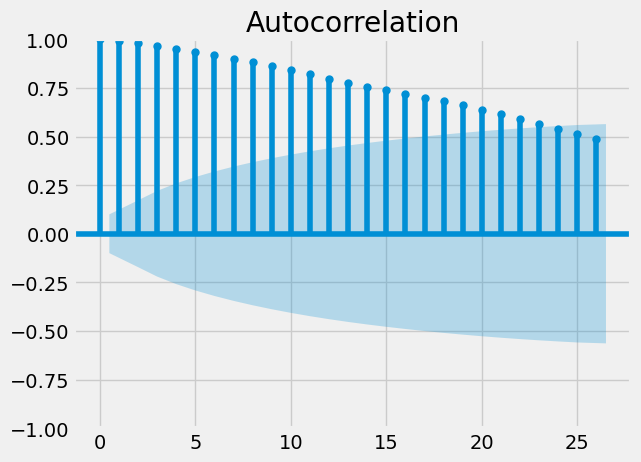

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



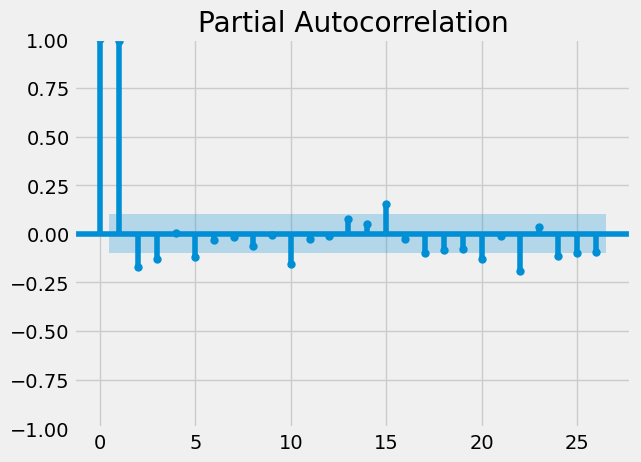

In [449]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df_plt[col]) #, lags=30, alpha=.05
plt.show()
plot_pacf(df_plt[col])
plt.show()

#### Predictions

In [409]:
# find cut of date
df_date = ts.copy()

#df_date['date'] = df_date['datetime'].dt.date
#df_date = df_date.drop(columns=['datetime'])

#Counts the distinct dates in the dataset, and sets the cut-off date based, on the sample percent that has been specified.
dates_list = df_date['datetime'].dt.date
dates_list = dates_list.to_frame().set_index('datetime')
dates_list = dates_list.index.unique()

sample = 0.30
sample_days = len(dates_list)*sample
cut_off = max(dates_list)
cut_off = cut_off - pd.Timedelta(sample_days, unit="D")
cut_off = np.datetime64(cut_off)
print(cut_off)

2023-02-14


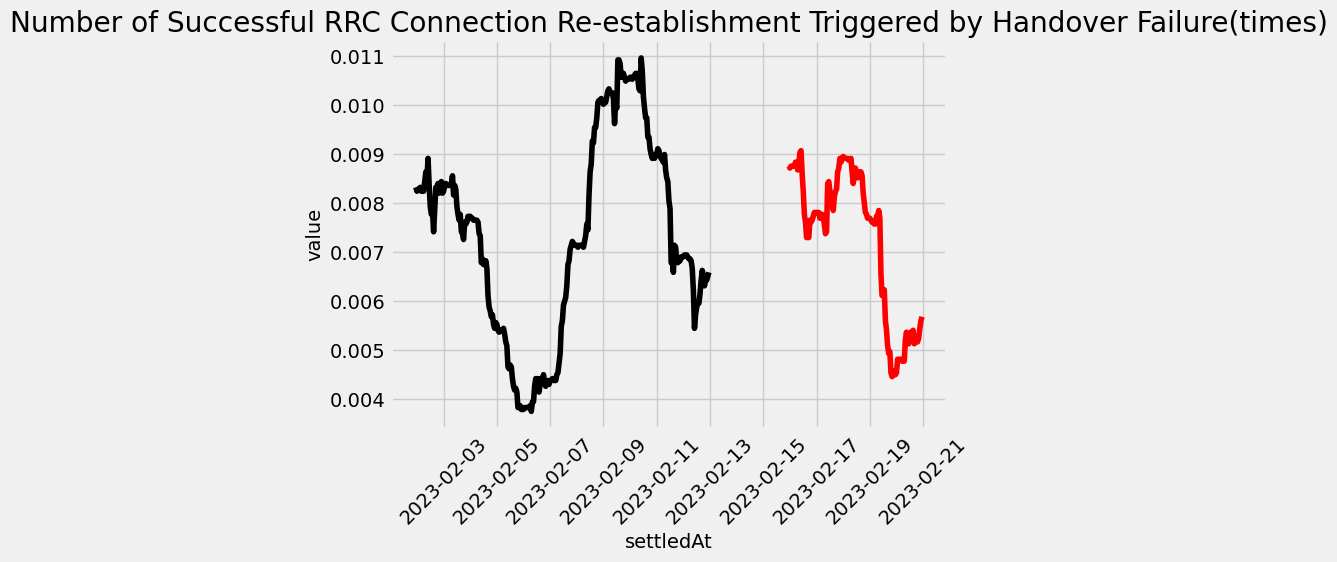

In [450]:
df_date = ts.copy()
df_date = df_date.set_index('datetime')

df_date = df_date.resample('H').mean()
df_date = df_date.rolling(window=48).mean()
df_date = df_date.dropna()

train_dateset = df_date.loc[df_date.index < cut_off]
pred_dateset =  df_date.loc[(df_date.index >= cut_off)&(df_date.index < cut_off + pd.Timedelta(180, unit="D"))]

plt.plot(train_dateset[col], color = "black")
plt.plot(pred_dateset[col], color = "red")

#plt.plot(train_dateset.groupby('datetime')[col].mean(), color = "black")
#plt.plot(pred_dateset.groupby('datetime')[col].mean(), color = "red")
plt.ylabel('value')
plt.xlabel('settledAt')
plt.xticks(rotation=45)
plt.title(col)
plt.show()

RMSE:  0.0016404511830366859


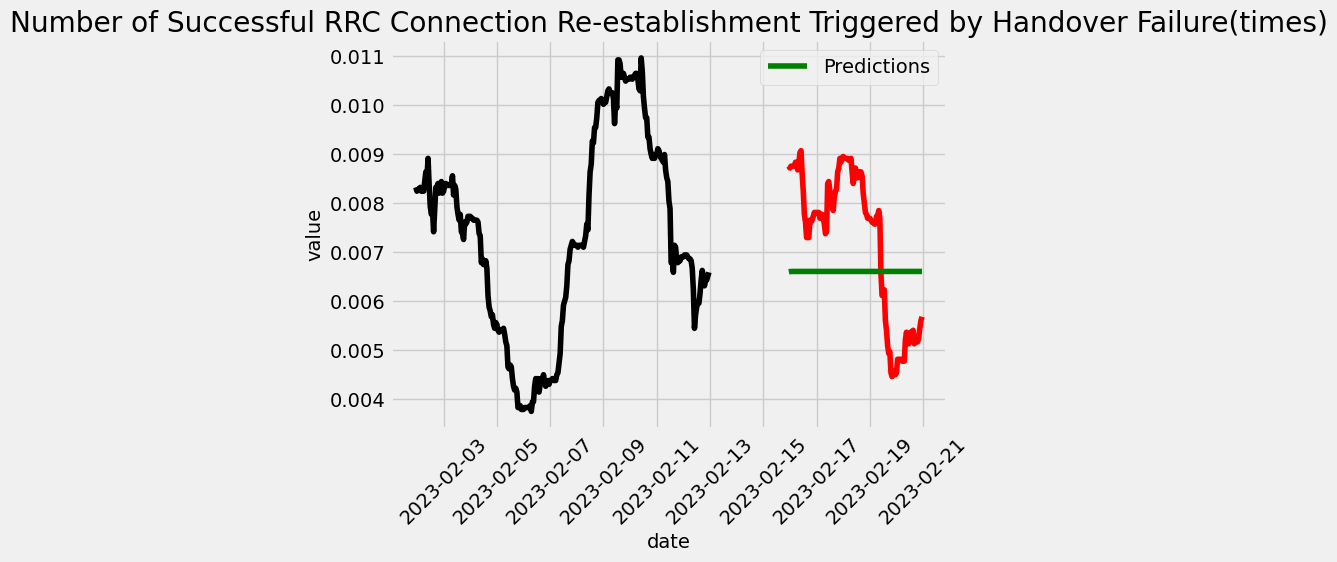

In [464]:
from statsmodels.tsa.arima.model import ARIMA

y_train = train_dateset.copy()
y = y_train[col] 
y.index = pd.DatetimeIndex(y.index).to_period('H')

test = pred_dateset[col]

ARIMAmodel = ARIMA(y, enforce_stationarity=False, enforce_invertibility=False, order = (1,1,1)) #(p,d,q) 
ARIMAmodel = ARIMAmodel.fit()
#print(ARIMAmodel.summary())

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.plot(train_dateset.groupby('datetime')[col].mean(), color = "black")
plt.plot(pred_dateset.groupby('datetime')[col].mean(), color = "red")
plt.plot(y_pred_out, color='green', label = 'Predictions')

plt.ylabel('value')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.title(col)
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test, y_pred_out))
print("RMSE: ",arma_rmse)

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



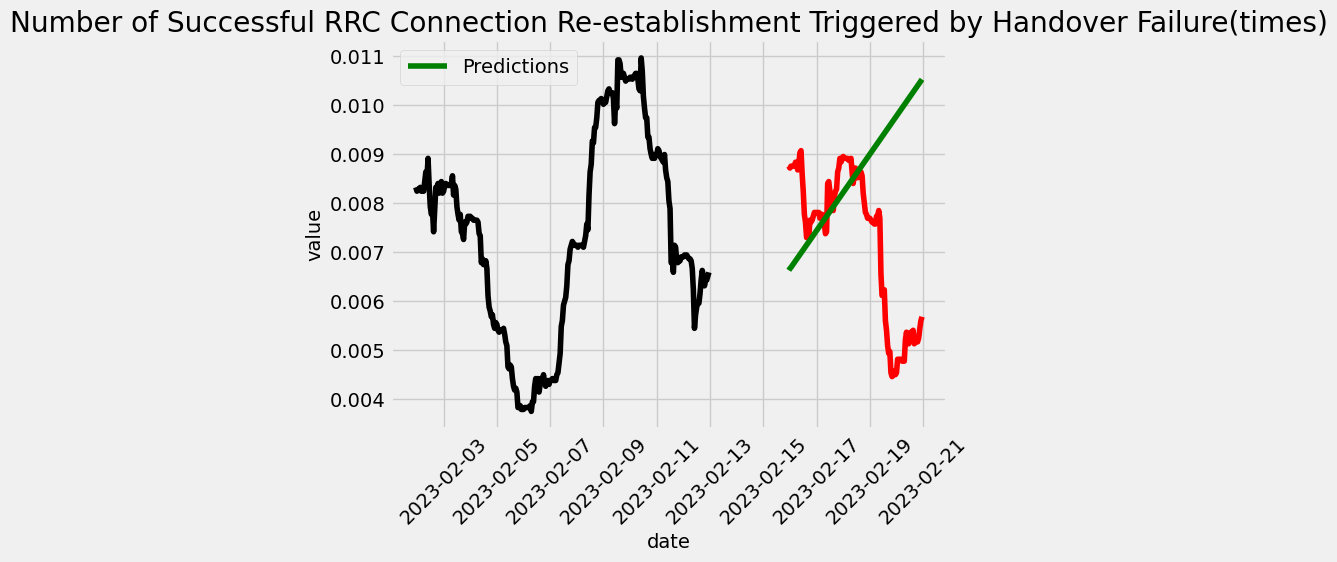

In [473]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#We can also evaluate the performance using the root mean-squared error:
import numpy as np
from sklearn.metrics import mean_squared_error

y_train = train_dateset.copy()
y = y_train[col] 
y.index = pd.DatetimeIndex(y.index).to_period('H')
test = pred_dateset[col]

ARMAmodel = SARIMAX(y, order=(1,2,4)) #order = (2, 3, 8)) ,seasonal_order=(0,1,0,12)
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.plot(train_dateset.groupby('datetime')[col].mean(), color = "black")
plt.plot(pred_dateset.groupby('datetime')[col].mean(), color = "red")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.ylabel('value')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.title(col)
plt.legend()

#arma_rmse = np.sqrt(mean_squared_error(test["total_flights"].values, y_pred_df["Predictions"]))
#print("RMSE: ",arma_rmse)